In [1]:
import os
import cudf
import cupy
import numpy as np
import pandas as pd
from platform import python_version

print(f'python version: {python_version()}')

python version: 3.7.9


In [2]:
train = cudf.read_csv('data/train.csv')
lectures = cudf.read_csv('data/lectures.csv')
questions = pd.read_csv('data/questions.csv')
test = cudf.read_csv('data/example_test.csv')

/home/hangyu/anaconda3/envs/cudf_py37/lib/python3.7/site-packages/fsspec/implementations/local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


### Basic Info

In [3]:
train.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype
---  ------                          -----
 0   row_id                          int64
 1   timestamp                       int64
 2   user_id                         int64
 3   content_id                      int64
 4   content_type_id                 int64
 5   task_container_id               int64
 6   user_answer                     int64
 7   answered_correctly              int64
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  bool
dtypes: bool(1), float64(1), int64(8)
memory usage: 6.9 GB


In [4]:
lectures.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   lecture_id  418 non-null    int64
 1   tag         418 non-null    int64
 2   part        418 non-null    int64
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 15.9+ KB


In [5]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [6]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,<NA>,<NA>
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False


In [7]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [8]:
lectures.type_of.unique()

0             concept
1           intention
2    solving question
3             starter
Name: type_of, dtype: object

In [9]:
questions.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [10]:
part_question_id = pd.DataFrame(questions.groupby('part').apply(lambda x: x['question_id'].unique())).reset_index().rename(columns = {0:"question_id"})

In [11]:
part_question_id

,part,question_id
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,"[196, 197, 198, 199, 200, 201, 202, 203, 204, ..."
2,3,"[1400, 1401, 1402, 1403, 1404, 1405, 1406, 140..."
3,4,"[2554, 2555, 2556, 2557, 2558, 2559, 2560, 256..."
4,5,"[3549, 3550, 3551, 3552, 3553, 3554, 3555, 355..."
5,6,"[6481, 6482, 6483, 6484, 6485, 6486, 6487, 648..."
6,7,"[6928, 6929, 6930, 6931, 6932, 6933, 6934, 693..."


### Missing Data

In [12]:
missing_portion = train.isnull().sum()/len(train)    
print(missing_portion.sort_values(ascending=False))

prior_question_elapsed_time       0.023230
prior_question_had_explanation    0.003877
row_id                            0.000000
timestamp                         0.000000
user_id                           0.000000
content_id                        0.000000
content_type_id                   0.000000
task_container_id                 0.000000
user_answer                       0.000000
answered_correctly                0.000000
dtype: float64


### 0.019 percent of content type are questions

In [13]:
np.sum(train.content_type_id) / train.shape[0]

0.019352223402764303

In [14]:
#0's are questions, 1's are lectures
train.content_type_id.value_counts()

0    99271300
1     1959032
Name: content_type_id, dtype: int32

In [15]:
print(f'number of users: {len(train.user_id.unique())}')
print(f'number of contents: {len(train.content_id.unique())}')

number of users: 393656
number of contents: 13782


In [16]:
content_id_count = train.content_id.value_counts()

In [17]:
content_id_count

6116     213605
6173     202106
4120     199372
175      195861
7876     190170
          ...  
10007         1
10008         1
10033         1
14429         1
21169         1
Name: content_id, Length: 13782, dtype: int32

In [18]:
pd.DataFrame(content_id_count.to_pandas()).to_csv('content_id_count.csv')

In [19]:
questions['tags'] = questions['tags'].astype(str)
tags = [x.split() for x in questions[questions.tags != "nan"].tags.values]
tags = [int(item) for elem in tags for item in elem]
tags = list(set(tags))

In [20]:
print(f'{len(tags)} unique tags')

188 unique tags


In [21]:
user_behavior = pd.DataFrame(train.groupby('user_id')['content_type_id'].sum().to_pandas())\
.reset_index().rename(columns={'content_type_id':'lectures_watched'})
user_behavior['total_interaction'] = train.groupby('user_id')['content_type_id'].count().to_arrow()
user_behavior['questions_answered'] = user_behavior['total_interaction'] - user_behavior['lectures_watched']
user_behavior = user_behavior.reindex(columns=['user_id','lectures_watched','questions_answered','total_interaction'])

In [22]:
user_behavior

,user_id,lectures_watched,questions_answered,total_interaction
0,115,0,46,46
1,124,0,30,30
2,2746,1,19,20
3,5382,3,125,128
4,8623,3,109,112
...,...,...,...,...
393651,2147470770,2,226,228
393652,2147470777,6,752,758
393653,2147481750,0,50,50
393654,2147482216,5,275,280


In [23]:
user_behavior.to_csv('user_behavior.csv')

### Find the hardest questions, tags, parts

In [24]:
train[train['content_type_id'] == 0][['user_id','content_id','answered_correctly']]

,user_id,content_id,answered_correctly
0,115,5692,1
1,115,5716,1
2,115,128,1
3,115,7860,1
4,115,7922,1
...,...,...,...
101230327,2147482888,3586,1
101230328,2147482888,6341,1
101230329,2147482888,4212,1
101230330,2147482888,6343,0


In [25]:
#Key: question_id
#value: tasks associated 
questions = questions[questions.question_id != 10033]
questions_tag = dict(zip(questions.question_id,questions.tags))
questions_tag = {key: [int(x) for x in value.split()] for key, value in questions_tag.items()}
questions_tag

{0: [51, 131, 162, 38],
 1: [131, 36, 81],
 2: [131, 101, 162, 92],
 3: [131, 149, 162, 29],
 4: [131, 5, 162, 38],
 5: [131, 149, 162, 81],
 6: [10, 94, 162, 92],
 7: [61, 110, 162, 29],
 8: [131, 13, 162, 92],
 9: [10, 164, 81],
 10: [131, 36, 38],
 11: [51, 131, 81],
 12: [51, 131, 92],
 13: [131, 5, 29],
 14: [131, 101, 38],
 15: [61, 110, 81],
 16: [131, 99, 92],
 17: [131, 93, 162, 29],
 18: [61, 110, 92],
 19: [10, 70, 162, 81],
 20: [131, 149, 162, 38],
 21: [9, 10, 162, 81],
 22: [131, 5, 92],
 23: [9, 10, 29],
 24: [9, 10, 38],
 25: [9, 10, 81],
 26: [131, 104, 162, 92],
 27: [9, 10, 29],
 28: [131, 104, 92],
 29: [131, 13, 162, 81],
 30: [51, 131, 162, 38],
 31: [131, 40, 162, 81],
 32: [131, 104, 162, 92],
 33: [131, 93, 162, 38],
 34: [9, 10, 92],
 35: [131, 5, 81],
 36: [131, 149, 162, 38],
 37: [131, 40, 81],
 38: [10, 70, 162, 92],
 39: [10, 94, 38],
 40: [131, 104, 38],
 41: [131, 93, 162, 81],
 42: [131, 130, 92],
 43: [131, 13, 162, 29],
 44: [9, 10, 38],
 45: [10, 1

In [26]:
tmp = train[train['content_type_id'] == 0][['content_id','answered_correctly']]
total_answered = tmp.groupby('content_id').count().to_pandas()
correct_answered = tmp.groupby('content_id').sum().to_pandas()
wrong_answered = total_answered - correct_answered

In [27]:
questions_correctness_df = pd.merge(correct_answered, total_answered , on='content_id')\
                          .rename(columns = {'answered_correctly_x':'right','answered_correctly_y':'total'})
questions_correctness_df['wrong'] = questions_correctness_df.total - questions_correctness_df.right
del questions_correctness_df['total']

In [28]:
#correctness by questions
questions_correctness_df

,right,wrong
content_id,,
0,6266,637
1,6589,809
2,24890,20015
3,17906,5067
4,19461,12275
...,...,...
13518,683,185
13519,528,396
13520,579,282


In [29]:
questions_correctness_df.to_csv('question_correctness.csv')

In [30]:
tags_correctness_dict = {}

for i in questions_tag.keys():
    for j in questions_tag[i]:
        if j not in tags_correctness_dict:
            tags_correctness_dict[j] = questions_correctness_df.iloc[i].values
        else:
            tags_correctness_dict[j] += questions_correctness_df.iloc[i].values

In [31]:
tags_correctness_dict

{51: array([257651,  65922]),
 131: array([3561810,  915163]),
 162: array([7056661, 2625291]),
 38: array([12014725,  4781603]),
 36: array([210287,  59112]),
 81: array([9831369, 4111769]),
 101: array([289828,  77641]),
 92: array([12932846,  5881489]),
 149: array([336639,  60334]),
 29: array([8699218, 3701328]),
 5: array([379318, 125044]),
 10: array([1692437,  863822]),
 94: array([299645, 235446]),
 61: array([299649, 121689]),
 110: array([299649, 121689]),
 13: array([155431,  53508]),
 164: array([284665, 161375]),
 99: array([220629,  77228]),
 93: array([456157, 107156]),
 70: array([235726,  58176]),
 9: array([630278, 319556]),
 104: array([369029, 109171]),
 40: array([184338,  42176]),
 130: array([207920,  35788]),
 187: array([215776,  36293]),
 102: array([6283353, 2708398]),
 111: array([180827,  50580]),
 178: array([236103,  88101]),
 143: array([5165286, 2079360]),
 30: array([807312, 333293]),
 90: array([1357071,  593855]),
 100: array([1244951,  521028]),
 1

In [32]:
tags_correctness_df = pd.DataFrame.from_dict(tags_correctness_dict, orient='index')
tags_correctness_df

,0,1
51,257651,65922
131,3561810,915163
162,7056661,2625291
38,12014725,4781603
36,210287,59112
...,...,...
68,104000,16378
3,187107,103171
165,19271,13670
59,23070,10575


In [33]:
tags_correctness_df.to_csv('tags_correctness.csv')

In [34]:
part_question_id

,part,question_id
0,1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,2,"[196, 197, 198, 199, 200, 201, 202, 203, 204, ..."
2,3,"[1400, 1401, 1402, 1403, 1404, 1405, 1406, 140..."
3,4,"[2554, 2555, 2556, 2557, 2558, 2559, 2560, 256..."
4,5,"[3549, 3550, 3551, 3552, 3553, 3554, 3555, 355..."
5,6,"[6481, 6482, 6483, 6484, 6485, 6486, 6487, 648..."
6,7,"[6928, 6929, 6930, 6931, 6932, 6933, 6934, 693..."


In [35]:
questions_correctness_df

,right,wrong
content_id,,
0,6266,637
1,6589,809
2,24890,20015
3,17906,5067
4,19461,12275
...,...,...
13518,683,185
13519,528,396
13520,579,282


In [36]:
part_correctness_dict = {}
for i in range(1,8):
    for j in part_question_id.iloc[i-1].question_id:
        if i not in part_correctness_dict:
            part_correctness_dict[i] = questions_correctness_df.iloc[j].values
        else:
            part_correctness_dict[i] += questions_correctness_df.iloc[j].values

In [37]:
part_correctness_df = pd.DataFrame.from_dict(part_correctness_dict, orient='index')
part_correctness_df

,0,1
1,5553896,1900674
2,13283339,5460065
3,6060514,2579393
4,5090684,2976992
5,24957570,15950583
6,7029563,3471909
7,3269061,1687057


In [38]:
part_correctness_df.to_csv('part_correctness.csv')

### Difficulty

In [39]:
questions_correctness_df = questions_correctness_df[questions_correctness_df['wrong'] + questions_correctness_df['right'] > 2]
questions_correctness_df['correct_rate'] = questions_correctness_df['right'] / (questions_correctness_df['right'] + questions_correctness_df['wrong'])
tags_correctness_df['correct_rate'] = tags_correctness_df[0] / (tags_correctness_df[0] + tags_correctness_df[1])
part_correctness_df['correct_rate'] = part_correctness_df[0] / (part_correctness_df[0] + part_correctness_df[1])

/home/hangyu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
questions_correctness_df

,right,wrong,correct_rate
content_id,,,
0,6266,637,0.907721
1,6589,809,0.890646
2,24890,20015,0.554281
3,17906,5067,0.779437
4,19461,12275,0.613215
...,...,...,...
13518,683,185,0.786866
13519,528,396,0.571429
13520,579,282,0.672474


In [41]:
tags_correctness_df

,0,1,correct_rate
51,257651,65922,0.796269
131,3561810,915163,0.795584
162,7056661,2625291,0.728847
38,12014725,4781603,0.715319
36,210287,59112,0.780578
...,...,...,...
68,104000,16378,0.863945
3,187107,103171,0.644579
165,19271,13670,0.585016
59,23070,10575,0.685689


In [42]:
part_correctness_df

,0,1,correct_rate
1,5553896,1900674,0.745032
2,13283339,5460065,0.708694
3,6060514,2579393,0.701456
4,5090684,2976992,0.630998
5,24957570,15950583,0.610088
6,7029563,3471909,0.669388
7,3269061,1687057,0.659601


In [43]:
##30 hardest question_id
thirty_hardest_question_id = questions_correctness_df.nsmallest(30, 'correct_rate')
thirty_hardest_question_id.to_csv('thirty_hardest_question_id.csv')

In [44]:
##30 easiest question_id
thirty_easiest_question_id = questions_correctness_df.nlargest(30, 'correct_rate')
thirty_easiest_question_id.to_csv('thirty_easiest_question_id.csv')

In [45]:
##30 hardest tag_id
thirty_hardest_tag_id = tags_correctness_df.nsmallest(30, 'correct_rate')
thirty_hardest_tag_id.to_csv('thirty_hardest_tag_id.csv')

In [46]:
##30 easiest tag_id
thirty_easiest_tag_id = tags_correctness_df.nlargest(30, 'correct_rate')
thirty_easiest_tag_id.to_csv('thirty_easiest_tag_id.csv')

### Machine Learning Part(working on it)

In [47]:
train = train[['row_id', 'user_id', 'answered_correctly', 'content_id', 'prior_question_had_explanation']]

In [48]:
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')

In [49]:
train = train.to_pandas()

In [72]:
user_df.to_csv('correctness_by_user_id.csv')

In [50]:
%%time
#adding user features
user_df = train[train.answered_correctly != -1].groupby('user_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
user_df.columns = ['user_id', 'user_questions', 'user_mean']

user_lect = train.groupby(["user_id", "answered_correctly"]).size().unstack()
user_lect.columns = ['Lecture', 'Wrong', 'Right']
user_lect['Lecture'] = user_lect['Lecture'].fillna(0)
user_lect = user_lect.astype('Int64')
user_lect['watches_lecture'] = np.where(user_lect.Lecture > 0, 1, 0)
user_lect = user_lect.reset_index()
user_lect = user_lect[['user_id', 'watches_lecture']]

user_df = user_df.merge(user_lect, on = "user_id", how = "left")
del user_lect
user_df.head()

CPU times: user 7.69 s, sys: 1.56 s, total: 9.25 s
Wall time: 9.24 s


,user_id,user_questions,user_mean,watches_lecture
0,115,46,0.695652,0
1,124,30,0.233333,0
2,2746,19,0.578947,1
3,5382,125,0.672000,1
4,8623,109,0.642202,1


In [51]:
%%time
#adding content features
content_df = train[train.answered_correctly != -1].groupby('content_id').agg({'answered_correctly': ['count', 'mean']}).reset_index()
content_df.columns = ['content_id', 'content_questions', 'content_mean']

CPU times: user 5.53 s, sys: 1.2 s, total: 6.74 s
Wall time: 6.73 s


In [52]:
def merge_fill_na(df):
    df = df.merge(user_df, on = "user_id", how = "left")
    df = df.merge(content_df, on = "content_id", how = "left")
    df['content_questions'].fillna(0, inplace = True)
    df['content_mean'].fillna(0.5, inplace = True)
    df['watches_lecture'].fillna(0, inplace = True)
    df['user_questions'].fillna(0, inplace = True)
    df['user_mean'].fillna(0.5, inplace = True)
    df[['content_questions', 'user_questions']] = df[['content_questions', 'user_questions']].astype(int)
    return(df)

In [53]:
train = merge_fill_na(train)
train.sample(5)

,row_id,user_id,answered_correctly,content_id,prior_question_had_explanation,user_questions,user_mean,watches_lecture,content_questions,content_mean
11976559,11976559,260313898,1,1783,True,419,0.809069,1,6536,0.578029
9038701,9038701,196705450,1,5192,True,31,0.935484,0,56461,0.523600
54065717,54065717,1146288866,1,6513,True,892,0.794843,1,4814,0.343997
12626142,12626142,273851632,1,4224,True,10102,0.612948,1,5485,0.839562
99137738,99137738,2103566656,0,439,True,6828,0.737991,1,17896,0.688031


In [54]:
train = train[:5000000]

In [55]:
X = train[['user_id', 'content_id', 'prior_question_had_explanation', 'user_questions', 'user_mean', 'watches_lecture', 'content_questions', 'content_mean' ]]
y = train['answered_correctly']

In [56]:
X['prior_question_had_explanation'] = X['prior_question_had_explanation'].astype('bool')

/home/hangyu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [58]:
import lightgbm as lgb


In [59]:
params = {'objective': 'binary',
          'metric': 'auc',
          'seed': 2020,
          'learning_rate': 0.1, #default
          "boosting_type": "gbdt" #default
         }

In [60]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = ['watches_lecture'])
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature = ['watches_lecture'])

In [61]:
%%time
model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=50,
    num_boost_round=10000,
    early_stopping_rounds=8
)

/home/hangyu/anaconda3/envs/cudf_py37/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 2576748, number of negative: 1423252
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1532
[LightGBM] [Info] Number of data points in the train set: 4000000, number of used features: 8


/home/hangyu/anaconda3/envs/cudf_py37/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/hangyu/anaconda3/envs/cudf_py37/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.644187 -> initscore=0.593584
[LightGBM] [Info] Start training from score 0.593584
Training until validation scores don't improve for 8 rounds
[50]	training's auc: 0.769361	valid_1's auc: 0.768964
[100]	training's auc: 0.771276	valid_1's auc: 0.770684
[150]	training's auc: 0.772207	valid_1's auc: 0.771466
[200]	training's auc: 0.772864	valid_1's auc: 0.771968
[250]	training's auc: 0.773367	valid_1's auc: 0.772301
[300]	training's auc: 0.773812	valid_1's auc: 0.772579
[350]	training's auc: 0.774277	valid_1's auc: 0.772851
[400]	training's auc: 0.774772	valid_1's auc: 0.773177
[450]	training's auc: 0.775164	valid_1's auc: 0.773365
[500]	training's auc: 0.775598	valid_1's auc: 0.773602
[550]	training's auc: 0.775975	valid_1's auc: 0.773801
[600]	training's auc: 0.776335	valid_1's auc: 0.773973
[650]	training's auc: 0.77669	valid_1's auc: 0.774135
[700]	training's auc: 0.777004	valid_1's auc: 0.774257
[750]	training's auc: 0.777313	valid_1's

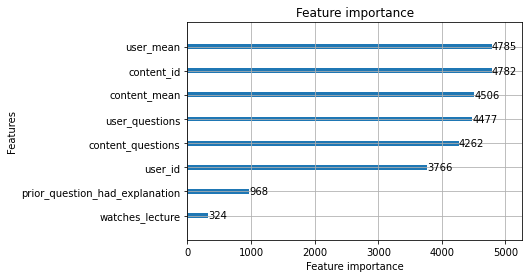

In [69]:
import matplotlib.pyplot as plt
lgb.plot_importance(model)
plt.show()

In [62]:
#we can do a A B test for group of users, if they have answered questions correctly given 
#if they have watched lectures before

In [63]:
#This is whole dataset
#Correctness by user?
#Correctness by question_id?
#Correctness by task?

In [70]:
#f = by_user + by_question 

In [ ]:
#build a classifier

In [ ]:
# questions
# lectures

In [ ]:
#Which features should be included in the model
#difficulty by questions and tags (continous number)
#prior_question_elapsed * if answered correctly

In [ ]:
#from train data, user's behavior with different level's questions. #match level
#user level